## Overview 

This script performs EDA and then preprocesses multiple datasets to train a bidirectional LSTM model which is in turn used to predict the sentiments behind Financial news headline and classify them as positive negative or neutral.



## Installing and importing dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
#import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


## Exploratory Data Analysis

### Cleaning and prepping dataset

In [2]:
# Load training dataset
df = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', names=['sentiment','sentence'])
# Output first five rows
df.head()

,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
# Check for missing data
df.isnull().sum()

sentiment    0
sentence     0
dtype: int64

In [4]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [5]:
# dimensionality of the data
# df1.shape

## Exploratory Data Analysis

Data Visualisation-

In [6]:
# The distribution of sentiments
df.groupby('sentiment').count().plot(kind='bar')

Plotting the distribution of headline lengths

In [7]:
df = df.rename(columns={'sentence': 'clean_text', 'sentiment':'category'})
df

,category,clean_text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [8]:
df['category'] = df['category'].map({'neutral': 'Neutral', 'positive': 'Positive', 'negative':'Negative'})


In [9]:
# Calculate headline lengths
headline_len = pd.Series([len(headline.split()) for headline in df['clean_text']])

# The distribution of headline text lengths
headline_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment headlines

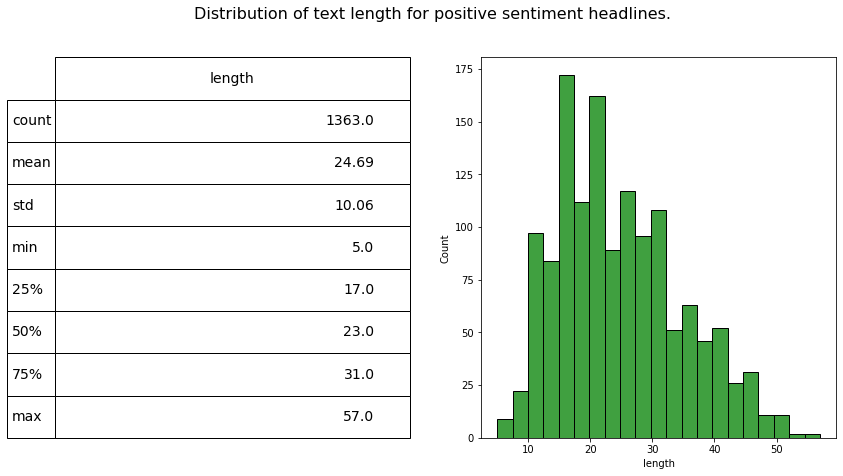

In [10]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment headlines.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment headlines.

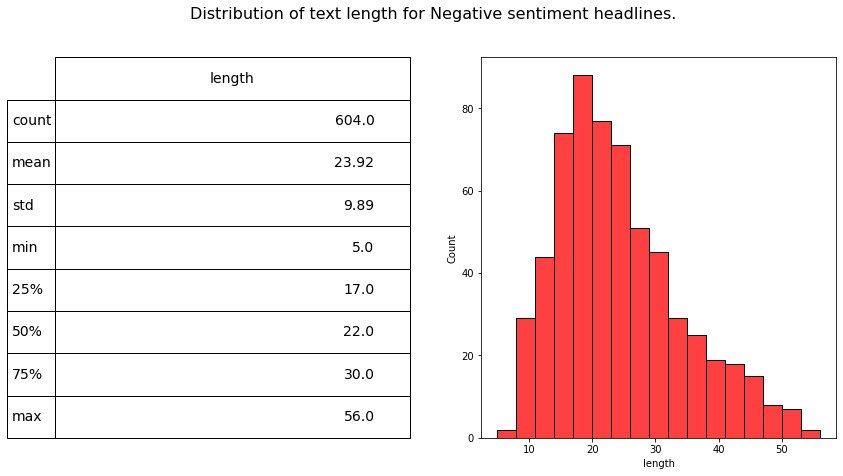

In [11]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment headlines.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the headlnies

In [12]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of headlines')
fig.show()

In [13]:
# #### Visualizing data into wordclouds


# from wordcloud import WordCloud, STOPWORDS

# def wordcount_gen(df, category):
#     '''
#     Generating Word Cloud
#     inputs:
#        - df: tweets dataset
#        - category: Positive/Negative/Neutral
#     '''
#     # Combine all tweets
#     combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
#     # Initialize wordcloud object
#     wc = WordCloud(background_color='white', 
#                    max_words=50, 
#                    stopwords = STOPWORDS)

#     # Generate and plot wordcloud
#     plt.figure(figsize=(10,10))
#     plt.imshow(wc.generate(combined_tweets))
#     plt.title('{} Sentiment Words'.format(category), fontsize=20)
#     plt.axis('off')
#     plt.show()
    
# # Positive tweet words
# wordcount_gen(df, 'Positive')
     
# # Negative tweet words
# wordcount_gen(df, 'Negative')
     
# # Neutral tweet words
# wordcount_gen(df, 'Neutral')
     


## Data Preprocessing

In [14]:
def headline_to_words(headline):
    ''' Convert headline text into a sequence of words '''
    
    # convert to lowercase
    text = headline.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal headline ->", df['clean_text'][0])
print("\nProcessed headline ->", headline_to_words(df['clean_text'][0]))


Original headline -> According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Processed headline -> ['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']


In [15]:
# Apply data processing to each headline
X = list(map(headline_to_words, df['clean_text']))

In [16]:
X

[['accord',
  'gran',
  'compani',
  'plan',
  'move',
  'product',
  'russia',
  'although',
  'compani',
  'grow'],
 ['technopoli',
  'plan',
  'develop',
  'stage',
  'area',
  'less',
  '100',
  '000',
  'squar',
  'meter',
  'order',
  'host',
  'compani',
  'work',
  'comput',
  'technolog',
  'telecommun',
  'statement',
  'said'],
 ['intern',
  'electron',
  'industri',
  'compani',
  'elcoteq',
  'laid',
  'ten',
  'employe',
  'tallinn',
  'facil',
  'contrari',
  'earlier',
  'layoff',
  'compani',
  'contract',
  'rank',
  'offic',
  'worker',
  'daili',
  'postime',
  'report'],
 ['new',
  'product',
  'plant',
  'compani',
  'would',
  'increas',
  'capac',
  'meet',
  'expect',
  'increas',
  'demand',
  'would',
  'improv',
  'use',
  'raw',
  'materi',
  'therefor',
  'increas',
  'product',
  'profit'],
 ['accord',
  'compani',
  'updat',
  'strategi',
  'year',
  '2009',
  '2012',
  'baswar',
  'target',
  'long',
  'term',
  'net',
  'sale',
  'growth',
  'rang',
  

In [17]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [18]:
print(X[0])
print(Y[0])

['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'compani', 'grow']
1


### Train and test split

In [19]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Bag of words (BOW) feature extraction

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# headline have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [21]:
import sklearn.preprocessing as pr

#Normalize BoW features in training and test set
X_train = pr.normalize(X_train, axis=1)
X_test  = pr.normalize(X_test, axis=1)

In [22]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

['0', '00', '000', '0025', '0030', '008', '01', '012', '0187274', '02', '023', '03', '030', '031', '04', '045', '046', '047', '05', '052', '06', '060', '063', '064', '07', '070', '08', '083', '084', '089', '09', '094', '0941', '1', '10', '100', '100mn', '101', '102', '1023', '103', '105', '106', '107', '10mn', '10th', '11', '110', '1112', '112', '113', '114', '115', '116', '117', '119', '11m', '12', '120', '122', '123', '125', '12mp', '12th', '13', '130', '133', '135', '138', '139', '14', '140', '141', '1411', '142', '143', '145', '146mn', '149', '14mn', '15', '150', '150mn', '151', '152', '154', '155', '156', '159', '15mn', '15th', '16', '160', '161', '162', '164', '1649', '167', '168', '17', '170', '172', '175', '1750', '177mn', '17m', '17mn', '18', '180', '180mn', '182', '184', '185', '186', '1862', '187', '189', '19', '190', '190mn', '191', '1910', '192', '1920', '1923', '193', '1930', '1944757', '1950', '196', '1960', '1964', '1966', '1970', '1987', '1989', '1994', '1995', '1996',

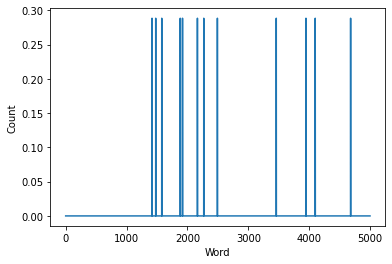

In [23]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Tokenizing & Padding

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len= 60

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
After Tokenization & Padding 
 [  94    5 3495    1   11   16  250  337    5  656  124   88    5  150
 2794   29   10  425    1   11   10  748    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


### Saving tokenized data

In [25]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [26]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (2907, 60) (2907, 3)
Validation Set -> (969, 60) (969, 3)
Test Set -> (970, 60) (970, 3)


In [27]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs= 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

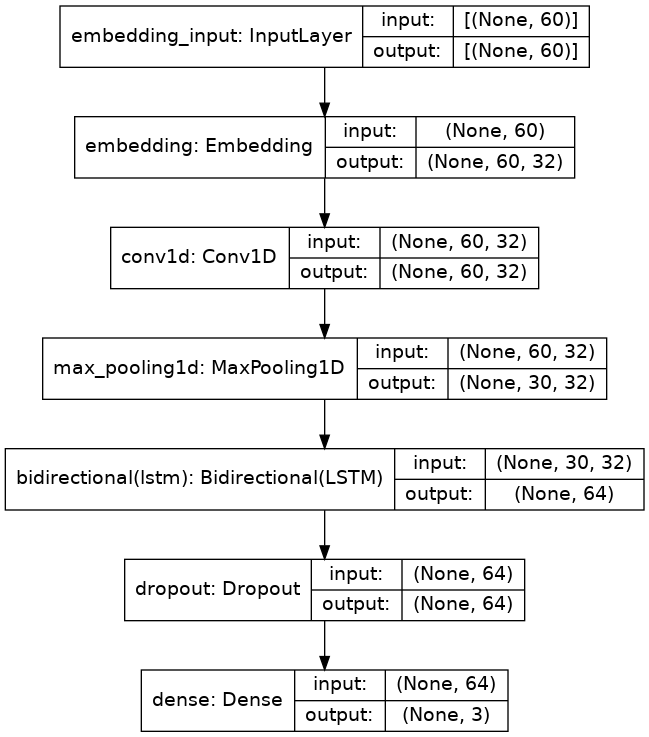

In [29]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

### Model Accuracy & Loss

In [31]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=1)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

31/31 [==============================] - 0s 8ms/step - loss: 1.6428 - accuracy: 0.6835 - precision: 0.6835 - recall: 0.6835

Accuracy  : 0.6835
Precision : 0.6835
Recall    : 0.6835
F1 Score  : 0.6835


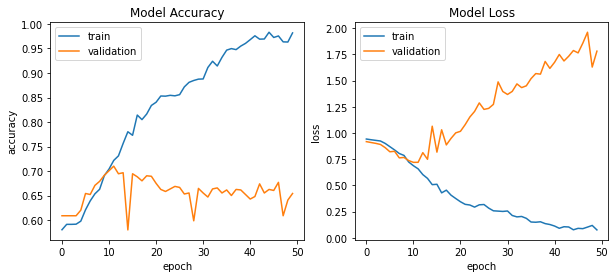

In [32]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

### Model Confusion Matrix

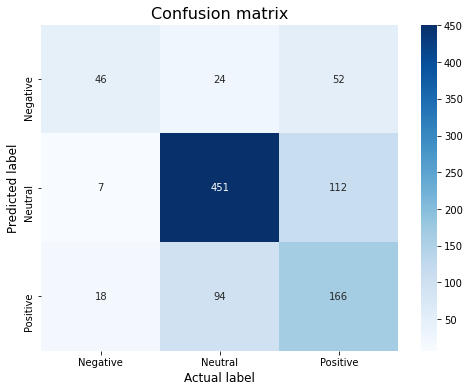

In [33]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [34]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [35]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [36]:
predict_class(['"I hate when I have to call and wake people up'])

The predicted sentiment is Positive


In [37]:
predict_class(['The food was meh'])

The predicted sentiment is Neutral


In [38]:
predict_class(['He is a best minister india ever had seen'])

The predicted sentiment is Positive
